Project image sequence colorization 

LACHOUQUE Jacque 
KOÏTA Adama


In [5]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import sys
import os

In [135]:
#%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting
from scipy.spatial import Delaunay

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [9]:
def imshow_plt(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    
def imshow_cv(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

(557, 362, 3)


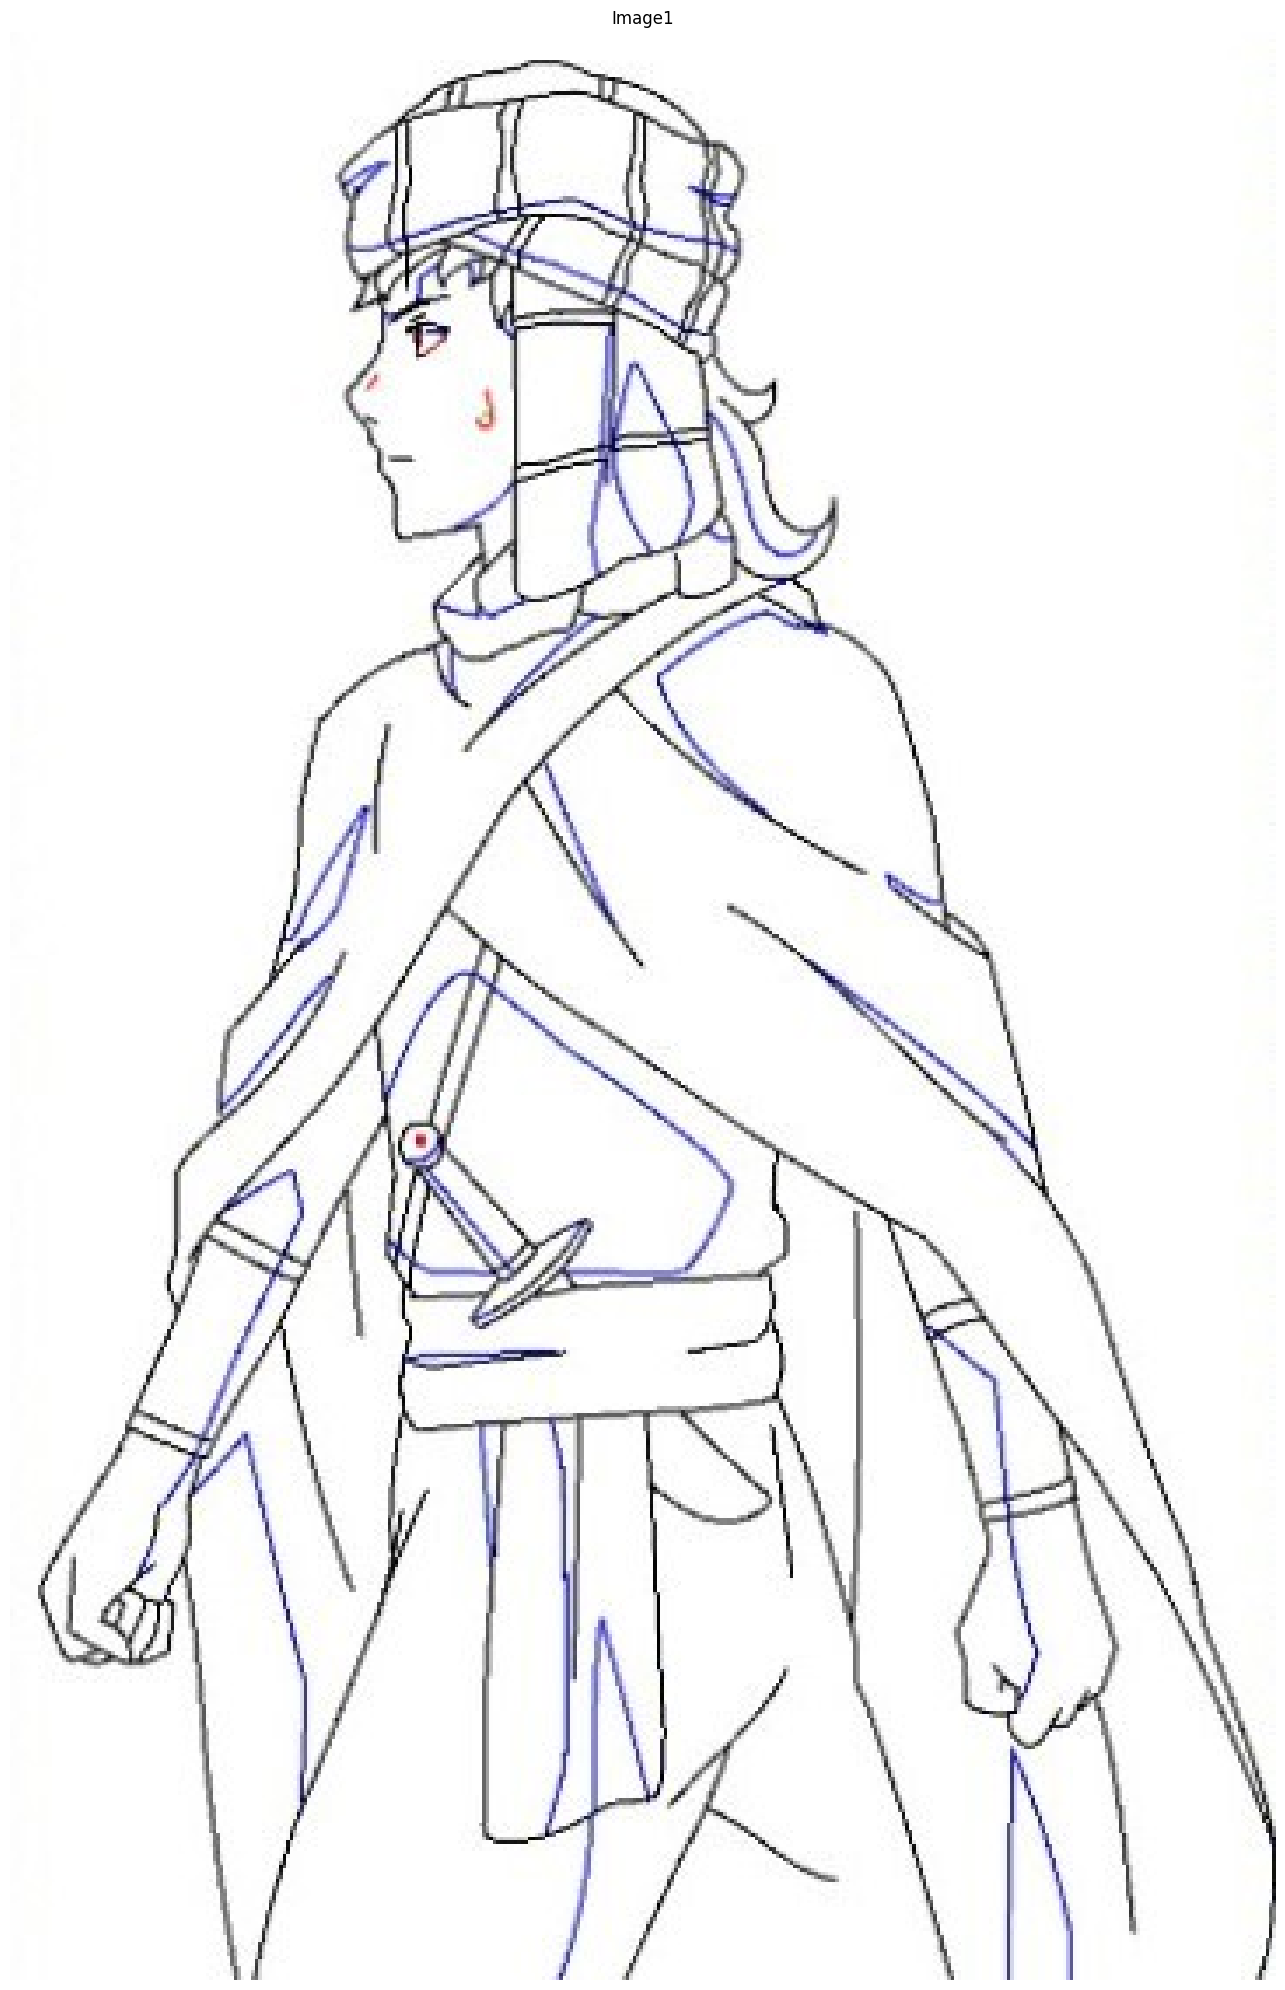

In [10]:
myimage = io.imread("dataset/sketch/1.jpg")
imshow_plt( [myimage], ['Image1'])
print(myimage.shape)

(557, 362, 3)


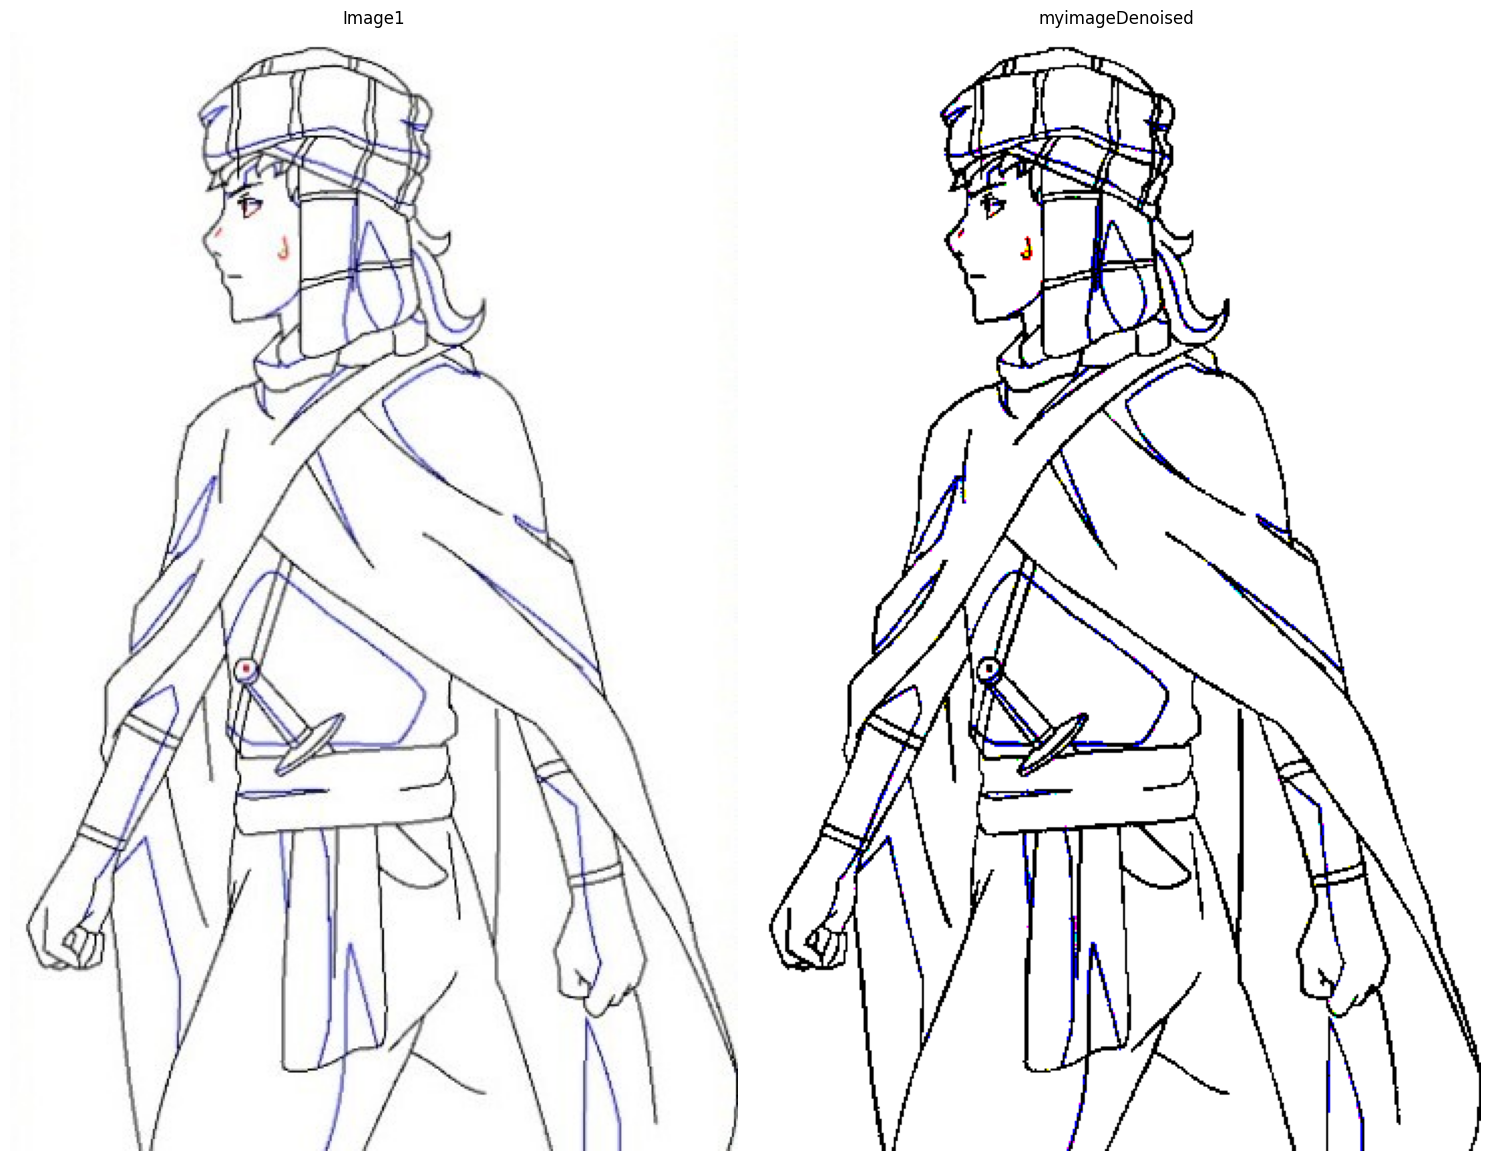

In [82]:
def threshold(img, value):
   """
   Delete noise and highligh the contours
   parameters:
      image : np.ndarray 
         image to denoise
      value : int
         treshold value of the pixel color
   returns:
      image denoised
   """
   return np.where(img <= value, 0, 255).astype(np.uint8)



myimage_denoised = threshold(myimage,200)
print(myimage_denoised.shape)
imshow_plt( [myimage, myimage_denoised], ['Image1', 'myimageDenoised'])


Here are some test 

(557, 362)


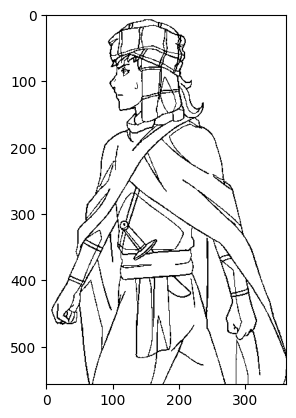

In [12]:
treatedPixMat = np.zeros((myimage.shape[0], myimage.shape[1]))
treatedPixMat =  np.where(
    (myimage_denoised[..., 0] == 255) & 
    (myimage_denoised[..., 1] == 255) & 
    (myimage_denoised[..., 2] == 255),
    
    treatedPixMat, -1
)
treatedPixMat =  np.where(
    (myimage_denoised[..., 0] != 255) & 
    (myimage_denoised[..., 1] != 255) & 
    (myimage_denoised[..., 2] != 255),
    
    treatedPixMat, 0
)
print(treatedPixMat.shape)
imshow_cv(treatedPixMat)

In [13]:
list_index_zeros = list(zip(*np.where(treatedPixMat == 0))) # * separe les deux array produit par np.where en deux array distinc et zip combine les élement pour les transformé en tuple
print(np.array(list_index_zeros).shape)
print(list_index_zeros[2])


(186526, 2)
(np.int64(0), np.int64(2))


In [14]:
print(treatedPixMat[0,50])

0.0


Some function to colorize an image

In [15]:
from random import randint

def apply_class_in_matrix_browsing_lines(classes_matrix,treated_pixels, class_num):

    new_treated_pixels = treated_pixels.copy()
    for line in range(classes_matrix.shape[0]):
        for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
           
            if(classes_matrix[line][col] == -1):
                    if(col !=0):
                        if(treated_pixels[line][col-1]):#and classes_matrix[line][col+1] ==0
                            continue
                        else:
                            break

                    
            if(classes_matrix[line][col] == 0):
                classes_matrix[line][col] = class_num
                new_treated_pixels[line][col] = True



        for col in range(classes_matrix.shape[1]-1,0,-1): #parcourir de la droite 
            if(classes_matrix[line][col] == -1 ):
                if(classes_matrix[line][col] == -1):
                    if(col !=classes_matrix.shape[1]-1):
                        if(treated_pixels[line][col+1]):#and classes_matrix[line][col+1] ==0
                            continue
                        else:
                            break
            if(classes_matrix[line][col] == 0):
                classes_matrix[line][col] = class_num
                new_treated_pixels[line][col] = True
                
    return  classes_matrix, new_treated_pixels




def classes_matrix_to_image(classes_matrix, list_class):
    image = np.zeros((classes_matrix.shape[0],classes_matrix.shape[1],3), dtype=int)
    for c in list_class:
        mask = (classes_matrix == c)
        random_color = (randint(0, 255), randint(0, 255), randint(0, 255))
        image[mask] = random_color
        #print("class "+ str(c)+" color:",random_color)
    return image

def assign_class_to_pixel_browse_by_lines(image):

    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
    

    print(classes_matrix.shape)
    
    last_class = 1
    classes_num_list = [1]
    show_steps = np.array([0,1,250])

    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)
    mask = (classes_matrix == -1)
    treated_pixels[mask] = True        
    #print(treated_pixels)

    while(np.isin(classes_matrix,0).any()):
        classes_matrix, new_treated_pixels = apply_class_in_matrix_browsing_lines(classes_matrix, treated_pixels,last_class)
        treated_pixels = new_treated_pixels.copy()
        #print("shape classes_matrix",classes_matrix.shape)
        #print("step",last_class-1)
        #imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        #print(classes_matrix[200])
        #imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])


        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list




(557, 362)
filling with denoised image


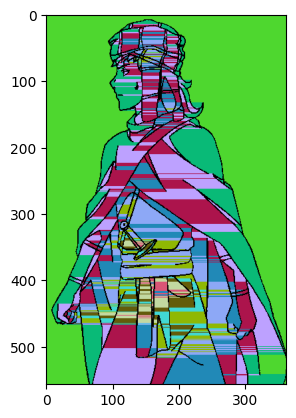

In [16]:
#classes_matrix ,classes_num_list  = assign_class_to_pixel_browse_by_lines(myimage)
#print("filling with raw image")
#imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
classes_matrix_image_denoised, classes_num_list_image_denoised = assign_class_to_pixel_browse_by_lines(myimage_denoised)
print("filling with denoised image")
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))


In [182]:

def filling(i,j,classes_matrix,treated_pixels, class_num ):
    #private function
    stack = [(i,j)] #utilisation de stack car probleme avec la recursion

    while stack :
        x,y = stack.pop()
        if(classes_matrix[x][y] == 0):
            classes_matrix[x][y] = class_num
            treated_pixels[x][y] = True
            if(x != 0):
                #classes_matrix = filling(x-1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x - 1, y))
            if(x != classes_matrix.shape[0]-1):
                #classes_matrix =filling(x+1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x + 1, y))
            if(y != 0):
                #classes_matrix =filling(x,y-1,classes_matrix,treated_pixels, class_num)
                stack.append((x, y - 1))
            if(y != classes_matrix.shape[1]-1):
                #classes_matrix =filling(x,y+1,classes_matrix,treated_pixels, class_num)
                stack.append((x , y+ 1))
    return classes_matrix

def delaunay_triangulate(image, treated_pixels):
    points = np.argwhere(~treated_pixels)
    if len(points) < 3:
        print("Pas assez de points pour la triangulation.")
        return None
    triangulation = Delaunay(points)
    #print(f"Nombre de triangles générés : {len(triangulation.simplices)}")
    return triangulation



def find_representative_circle(triangulation, region_points):
    max_circle = None
    max_area = 0
    found = False
    for simplex in triangulation.simplices:
        try:
            triangle_points = triangulation.points[simplex]
            circumcenter, radius = compute_circumcircle(triangle_points)
            if all(np.linalg.norm(region_points - circumcenter, axis=1) <= radius):
                area = np.pi * radius**2
                if area > max_area:
                    max_area = area
                    max_circle = (circumcenter, radius)
                    found = True
        except ValueError as e:
            continue
    #if not found:
        #print("Aucun cercle représentatif trouvé.")
    return max_circle



def compute_circumcircle(points):
    # Vérifie que `points` contient exactement 3 points
    if points.shape != (3, 2):
        raise ValueError("Les points doivent être une liste de trois coordonnées 2D.")

    # Matrice pour le calcul du cercle circonscrit
    A = np.array([
        [points[0][0], points[0][1], 1],
        [points[1][0], points[1][1], 1],
        [points[2][0], points[2][1], 1]
    ])
    B = np.array([
        [points[0][0]**2 + points[0][1]**2],
        [points[1][0]**2 + points[1][1]**2],
        [points[2][0]**2 + points[2][1]**2]
    ])
    
    # Vérifie que la matrice A est carrée et non singulière
    if np.linalg.det(A) == 0:
        raise ValueError("Les points donnés forment un triangle dégénéré (colinéaire).")
    
    circumcenter = np.linalg.solve(A[:, :-1], B).flatten() / 2
    radius = np.sqrt(np.sum((points[0] - circumcenter)**2))
    return circumcenter, radius


def delaunay_filling(i, j, classes_matrix, treated_pixels, class_num):
    stack = [(i, j)]
    region_points = []
   # Étape 1 : Collecte des points de la région
    while stack:
        x, y = stack.pop()
        if not treated_pixels[x, y] and classes_matrix[x, y] == 0:
            treated_pixels[x, y] = True
            region_points.append([x, y])
            # Ajout des voisins, en évitant les bords et les contours (-1)
            if x > 0 and classes_matrix[x - 1, y] != -1:
                stack.append((x - 1, y))
            if x < classes_matrix.shape[0] - 1 and classes_matrix[x + 1, y] != -1:
                stack.append((x + 1, y))
            if y > 0 and classes_matrix[x, y - 1] != -1:
                stack.append((x, y - 1))
            if y < classes_matrix.shape[1] - 1 and classes_matrix[x, y + 1] != -1:
                stack.append((x, y + 1))
    
    # Étape 2 : Vérification des points collectés
    if len(region_points) < 3:
        # Pas assez de points pour former une triangulation
        for x, y in region_points:
            classes_matrix[x, y] = class_num
        return classes_matrix

    # Étape 3 : Triangulation de Delaunay
    region_points = np.array(region_points)
    triangulation = delaunay_triangulate(classes_matrix, treated_pixels)
    if triangulation is None:
        # Si aucune triangulation valide n'est possible
        for x, y in region_points:
            classes_matrix[x, y] = class_num
        return classes_matrix

    # Étape 4 : Trouver et remplir avec les cercles représentatifs
    circle = find_representative_circle(triangulation, region_points)
    if circle:
        center, radius = circle
        for x, y in region_points:
            if np.linalg.norm(np.array([x, y]) - center) <= radius:
                classes_matrix[x, y] = class_num
    else:
        # Si aucun cercle valide n'est trouvé, remplir directement
        for x, y in region_points:
            classes_matrix[x, y] = class_num
    
    return classes_matrix



def assign_class_to_pixel_by_filling(image, filling_function="delaunay_filling"):


    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
   
    print(classes_matrix.shape)
    #imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = [1]
    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)

    mask_contour = (classes_matrix == -1) # -1 is the value of contours 
    treated_pixels[mask_contour] = True        
    while(np.isin(classes_matrix,0).any()):
        #classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        #treated_pixels = new_treated_pixels.copy()
        fill = False
        for line in range(classes_matrix.shape[0]):
            for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
                if(classes_matrix[line][col] == 0):
                    if(filling_function == "basic_filling"):
                        filling(line, col,classes_matrix, treated_pixels,last_class)
                    elif(filling_function == "delaunay_filling"):
                        delaunay_filling(line, col, classes_matrix, treated_pixels,last_class)
                    fill =True

                    break
            if(fill): break  
        """print("step",last_class-1)
        imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        print(classes_matrix[200])
        imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])"""
        
        
        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list


filling with denoised image
(557, 362)
Nombre de triangles générés : 196781
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 196253
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 196234
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 196210
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 195976
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 195917
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 194035
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 192505
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 192362
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 192230
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 191374
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 191219
Aucun cercle représentatif trouvé.
Nombre de triangles générés : 190727
Aucun cercle représentatif trouvé.
Nombre de triangles génér

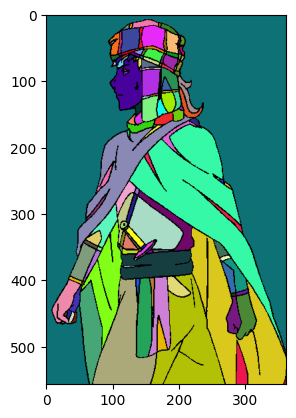

In [178]:
#classes_matrix, classes_num_list = assign_class_to_pixel_by_filling(myimage)
#print("filling with raw image")
#imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
print("filling with denoised image")
classes_matrix_image_denoised, classes_num_list_image_denoised = assign_class_to_pixel_by_filling(myimage_denoised,"delaunay_filling")
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))

(526, 478, 3)


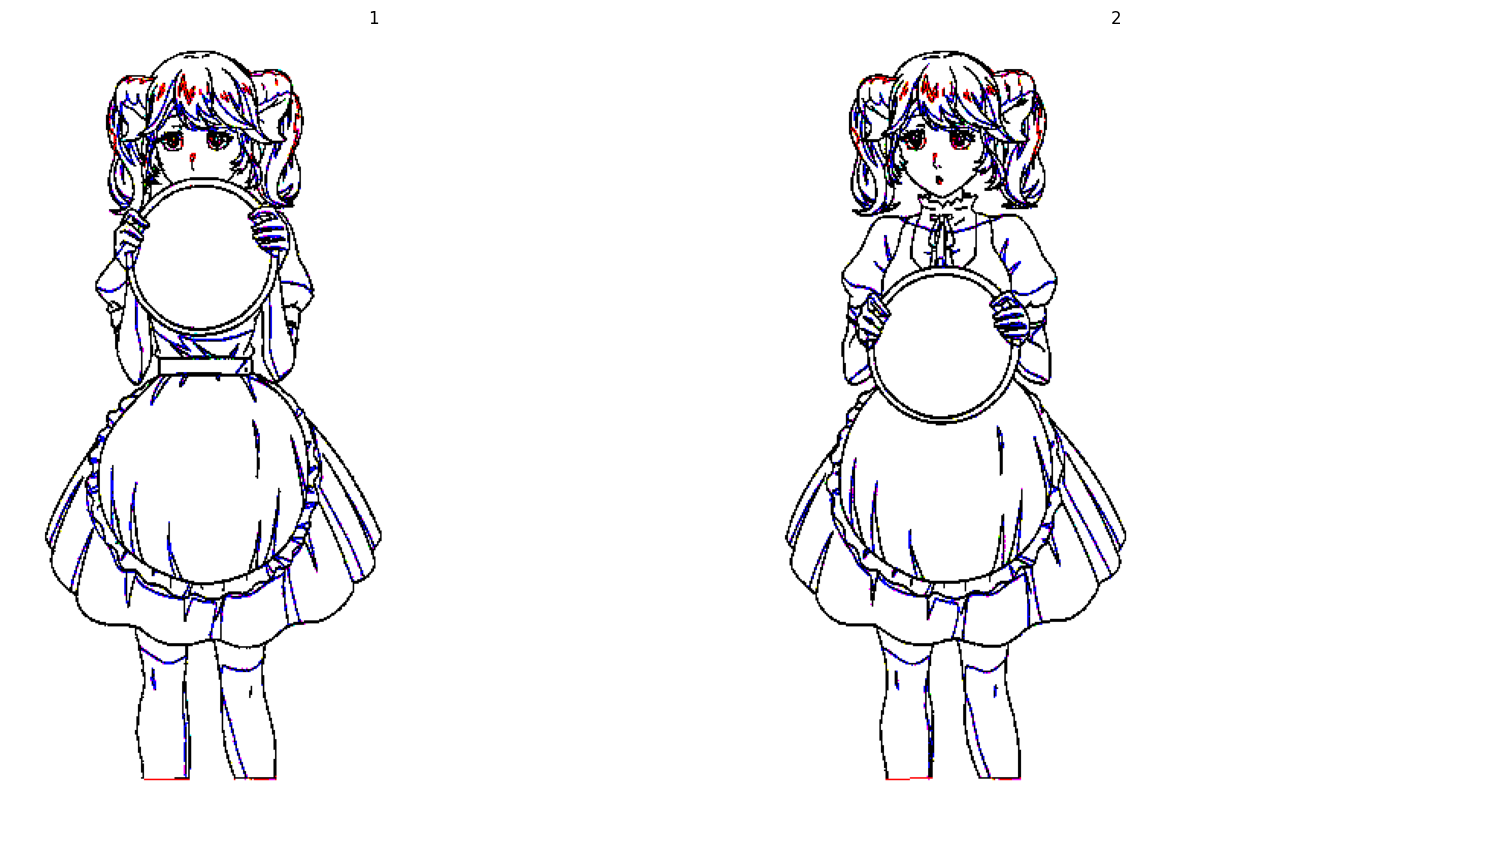

In [19]:
image_references = [ cv2.cvtColor(cv2.imread("dataset/colored/sequence1/1.png"), cv2.COLOR_BGR2RGB )]
images = [threshold(cv2.cvtColor(cv2.imread("dataset/sketch/sequence1/1.png"), cv2.COLOR_BGR2RGB ),220), threshold(cv2.cvtColor(cv2.imread("dataset/sketch/sequence1/4.png"), cv2.COLOR_BGR2RGB),220)]

imshow_plt( images, ['1', '2'])
print(images[0].shape)


# verifier avec les homographies



(526, 478)
Apply pixel from previous to new


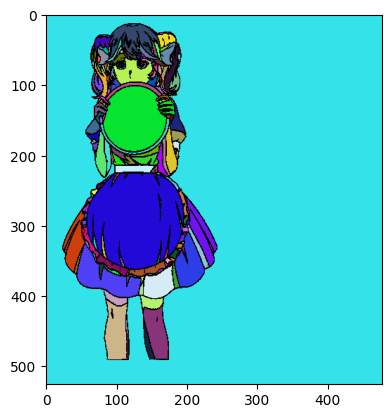

In [ ]:
#color first image 
classes_matrix , classes_num_list = assign_class_to_pixel_by_filling(images[0],filling)
image_colored = classes_matrix_to_image(classes_matrix, classes_num_list)
print('Apply pixel from previous to new')
imshow_cv(image_colored)

In [21]:

from collections import Counter

def assign_color_to_class_from_reference(image_classes, list_classes, image_reference):
    """ 
    This class allows to assign a color to each image class from the reference image
    parameters:
        -image_classes : np.ndarray 
            matrix of the classes associated to each pixel
        - list_classes : list 
            list of classes values
        image_reference : np.ndarray
            colored image reference
    """
    output_image = np.zeros((*image_classes.shape, 3), dtype=int)

    for c in list_classes:
        mask = (image_classes == c)
        indices = np.argwhere(mask)

        if len(indices) > 0:
            colors = [tuple(image_reference[i, j]) for i, j in indices]
            most_common_color = Counter(colors).most_common(1)[0][0]

            # Assigner la couleur trouvée à tous les pixels de la classe
            output_image[mask] = (most_common_color[0], most_common_color[1],most_common_color[2])

    return output_image

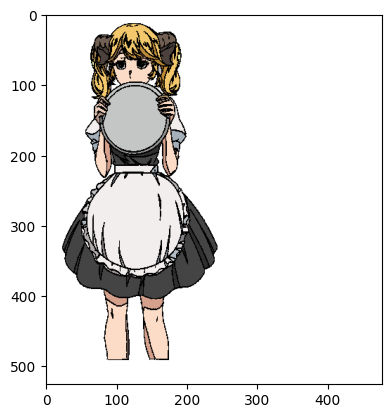

In [22]:
image_color_from_sketch = assign_color_to_class_from_reference(classes_matrix,classes_num_list, image_references[0])
imshow_cv(image_color_from_sketch)


In [23]:
import cv2
from skimage import io

# Preprocessing Function
def preprocess_image(image, is_sketch=False):
    """
    Preprocesses the input image.
    For colored image: Apply edge detection.
    For sketch: Apply thresholding.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if is_sketch:
        _, thresholded = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
        return thresholded
    else:
        edges = cv2.Canny(gray, 100, 200)
        return edges

# Keypoint Extraction Function
def extract_key_points(img1, img2):
    akaze = cv2.AKAZE_create()
    # Detect and compute key points and descriptors for each image
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)
    return kp1, des1, kp2, des2

# Matching Keypoints
def match_key_points(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    return sorted(matches, key=lambda x: x.distance)

# Homography Estimation
def find_homography(matches, kp1, kp2):
    src_pts = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
    dst_pts = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    inliers = [matches[m] for m in range(len(matches)) if mask[m] == 1]

    return H, inliers


colored_image = io.imread("dataset/colored/sequence1/1.png")
sketch_image = io.imread("dataset/sketch/sequence1/1.png")

# Preprocess images
preprocessed_colored = preprocess_image(colored_image, is_sketch=False)
preprocessed_sketch = preprocess_image(sketch_image, is_sketch=True)

# Extract key points and descriptors
kp1, des1, kp2, des2 = extract_key_points(colored_image, sketch_image)

# Match key points
matches = match_key_points(kp1, des1, kp2, des2)

# Find homography
if len(matches) >= 4:  # Minimum of 4 matches required
    H, inliers = find_homography(matches, kp1, kp2)
    print("Homography matrix:\n", H)
else:
    print("Not enough matches to compute homography.")

Homography matrix:
 [[1.00214582e+00 5.79046702e-03 5.08994811e-01]
 [4.63404036e-04 1.00538119e+00 1.54195871e-01]
 [2.13001362e-05 4.58802085e-05 1.00000000e+00]]


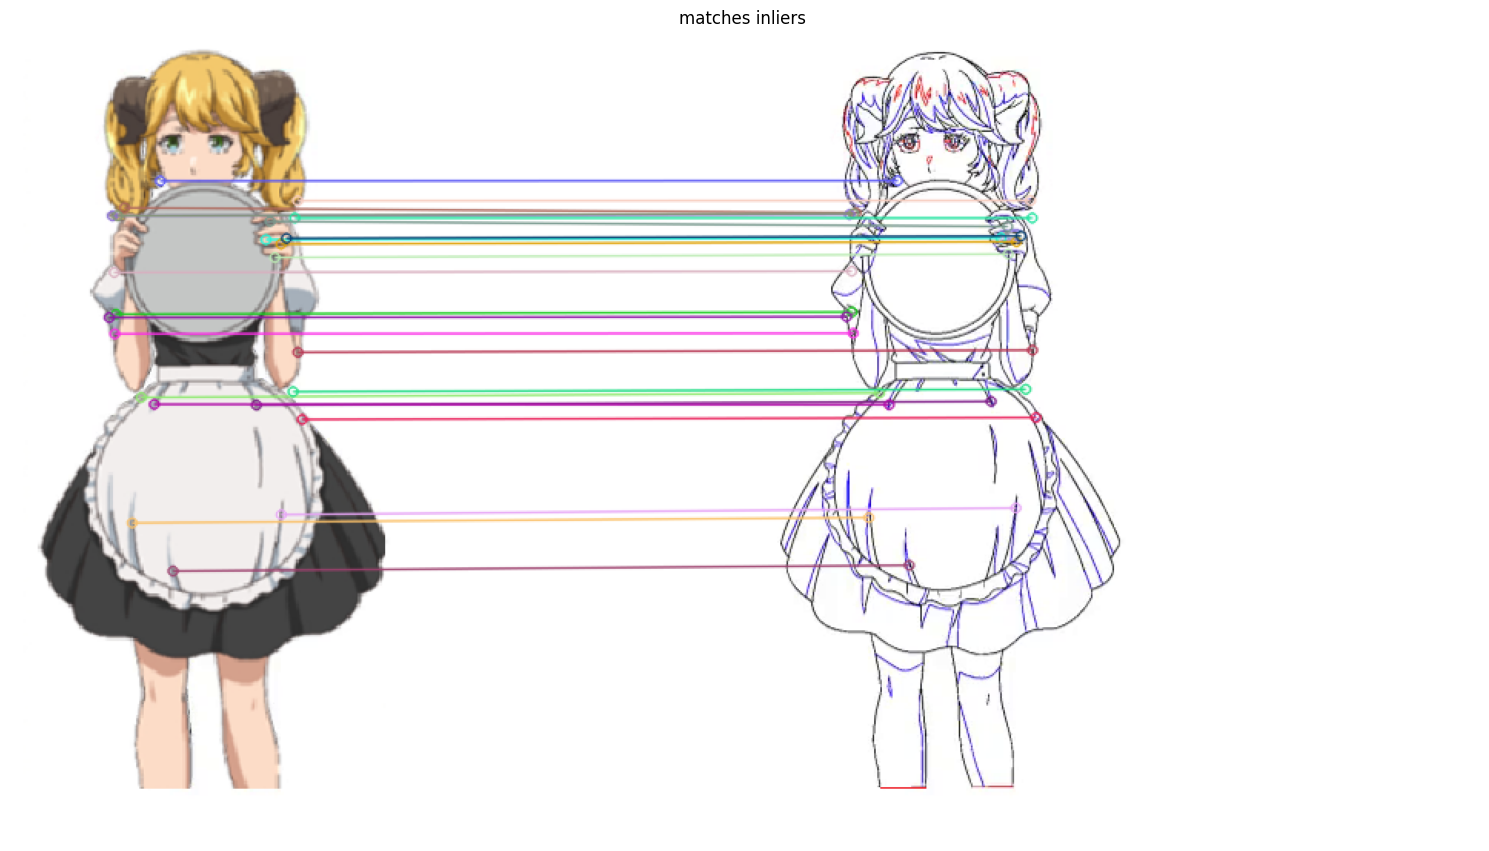

In [24]:

def showMatches(img1, kp1, img2, kp2, matches, name):
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
    imshow_plt([img],[name])

showMatches(colored_image, kp1,sketch_image, kp2, inliers, "matches inliers ")


Homography matrix:
 [[1.00214582e+00 5.79046702e-03 5.08994811e-01]
 [4.63404036e-04 1.00538119e+00 1.54195871e-01]
 [2.13001362e-05 4.58802085e-05 1.00000000e+00]]


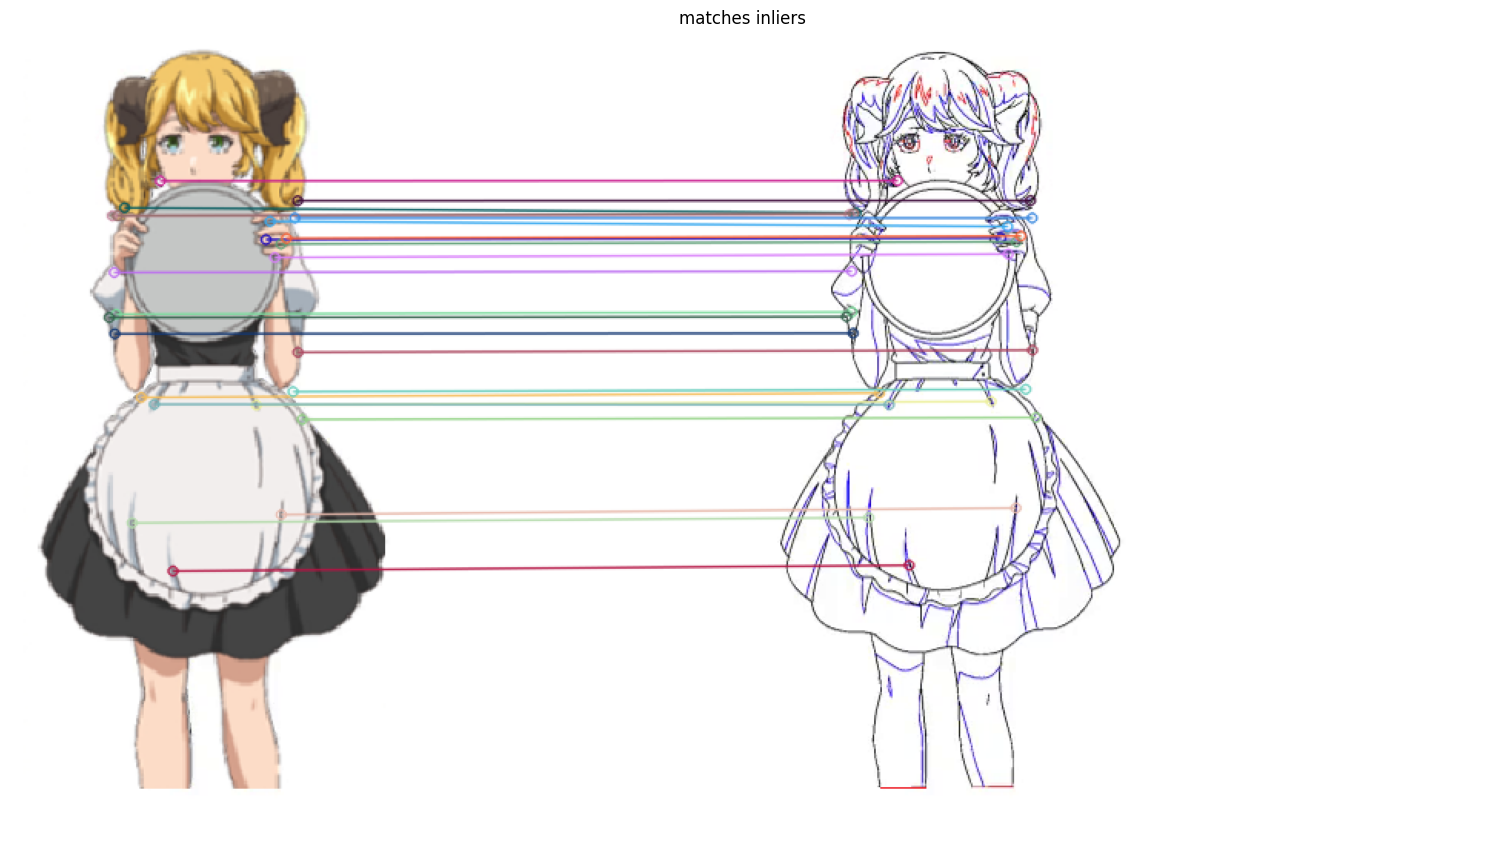

In [25]:
# for each matches I apply the color  i superpose the images then i apply the colors. For the 


# Extract key points and descriptors
kp1, des1, kp2, des2 = extract_key_points(colored_image, sketch_image)

# Match key points
matches = match_key_points(kp1, des1, kp2, des2)

# Find homography
if len(matches) >= 4:  # Minimum of 4 matches required
    H, inliers = find_homography(matches, kp1, kp2)
    print("Homography matrix:\n", H)
else:
    print("Not enough matches to compute homography.")



showMatches(colored_image, kp1,sketch_image, kp2, inliers, "matches inliers ")


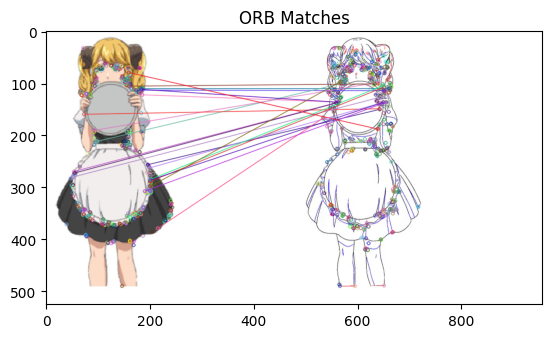

In [26]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
kp1, des1 = orb.detectAndCompute(colored_image, None)
kp2, des2 = orb.detectAndCompute(sketch_image, None)

# Match descriptors using BFMatcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
result = cv2.drawMatches(colored_image, kp1, sketch_image, kp2, matches[:20], None)

# Display result
plt.imshow(result)
plt.title("ORB Matches")
plt.show()


In [27]:
def preprocess_images(color_image, sketch_image):
    # Convert to grayscale
    gray_color = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    # Apply edge detection
    edges_color = cv2.Canny(gray_color, 50, 150)
    edges_sketch = cv2.Canny(sketch_image, 50, 150)
    return edges_color, edges_sketch


def extract_keypoints_and_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


def match_keypoints(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches


def compute_homography(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

def warp_color_image(color_image, H, sketch_shape):
    warped_color = cv2.warpPerspective(color_image, H, (sketch_shape[1], sketch_shape[0]))
    return warped_color


def transfer_colors(warped_color, sketch):
    # Convert sketch to 3 channels
    sketch_rgb = cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)
    # Create a mask for the sketch
    mask = (sketch > 200).astype(np.uint8)  # Threshold for white areas
    mask = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    # Blend colors
    colored_sketch = cv2.bitwise_and(warped_color, mask) + cv2.bitwise_and(sketch_rgb, 255 - mask)
    return colored_sketch

def smooth_colors(colored_image):
    smoothed = cv2.bilateralFilter(colored_image, 9, 75, 75)
    return smoothed


In [28]:
def colorize_sketch_sequence(color_image, sketch_sequence):
    colorized_sequence = []
    for sketch in sketch_sequence:
        # Preprocess images
        edges_color, edges_sketch = preprocess_images(color_image, sketch)
        kp1, des1 = extract_keypoints_and_descriptors(edges_color)
        kp2, des2 = extract_keypoints_and_descriptors(edges_sketch)

        # Match keypoints
        matches = match_keypoints(des1, des2)
        if len(matches) < 4:  # Homography requires at least 4 matches
            print("Not enough matches for sketch!")
            colorized_sequence.append(None)
            continue

        # Compute homography and warp
        H = compute_homography(kp1, kp2, matches)
        warped_color = warp_color_image(color_image, H, sketch.shape)

        # Transfer colors
        colored_sketch = transfer_colors(warped_color, sketch)

        # Smooth the result
        smoothed = smooth_colors(colored_sketch)
        colorized_sequence.append(smoothed)

    return colorized_sequence


In [29]:
# Charger l'image colorée et la séquence de sketches
color_image = cv2.imread("dataset/colored/sequence1/1.png")
sketch_sequence = [cv2.imread(f"dataset/sketch/sequence1/{i}.png", cv2.IMREAD_GRAYSCALE) for i in range(1, 11)]

# Coloriser la séquence
colorized_sequence = colorize_sketch_sequence(color_image, sketch_sequence)

# Afficher les résultats
for i, colored_image in enumerate(colorized_sequence):
    if colored_image is not None:
        cv2.imshow(f"Colored Sketch {i+1}", colored_image)
        cv2.waitKey(0)

cv2.destroyAllWindows()


In [30]:
#pourquoi pas decouper limage en plusieurs patchs.  puis associé chaque patch au sketch precedent puis appliqué la couelur. les patch ou il n'y a pas de correposndance on fait de l'inpainting ?
def split_into_patches(image, patch_size):
    """
    Découpe une image en patchs de taille donnée.
    """
    h, w = image.shape[:2]
    patches = []
    positions = []  # Conserver les coordonnées des patchs
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def extract_features_from_patches(patches):
    """
    Extrait des caractéristiques des patchs à l'aide d'ORB.
    """
    orb = cv2.ORB_create()
    features = []
    for patch in patches:
        kp, des = orb.detectAndCompute(patch, None)
        features.append(des)  # Ajouter les descripteurs
    return features

def match_patches(features_sketch, features_color):
    """
    Associe les patchs entre le sketch et l'image colorée.
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = []
    for idx, sketch_feature in enumerate(features_sketch):
        if sketch_feature is not None:
            best_match = None
            best_distance = float('inf')
            for j, color_feature in enumerate(features_color):
                if color_feature is not None:
                    match = bf.match(sketch_feature, color_feature)
                    distance = sum([m.distance for m in match])
                    if distance < best_distance:
                        best_distance = distance
                        best_match = j
            matches.append((idx, best_match))
        else:
            matches.append((idx, None))
    return matches

def match_patches_between_sketches(sketch1, sketch2, patch_size):
    """
    Fait correspondre les patchs entre deux sketchs.
    """
    # Étape 1: Découper les deux sketchs en patchs
    patches1, positions1 = split_into_patches(sketch1, patch_size)
    patches2, positions2 = split_into_patches(sketch2, patch_size)
    
    # Étape 2: Extraire les caractéristiques des patchs
    features1 = extract_features_from_patches(patches1)
    features2 = extract_features_from_patches(patches2)
    
    # Étape 3: Faire correspondre les patchs
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = []
    
    for idx1, feature1 in enumerate(features1):
        if feature1 is None:
            matches.append((idx1, None))  # Aucun match trouvé
            continue
        
        best_match_idx = None
        best_distance = float('inf')
        
        for idx2, feature2 in enumerate(features2):
            if feature2 is not None:
                match = bf.match(feature1, feature2)
                distance = sum([m.distance for m in match])
                if distance < best_distance:
                    best_distance = distance
                    best_match_idx = idx2
        
        matches.append((idx1, best_match_idx))  # Associer les indices des patchs
    
    return matches, positions1, positions2


In [31]:
def threshold_cv(img, value):
    if len(img.shape) == 3:  
        # Convertir en niveaux de gris
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
        
    _, thresholded = cv2.threshold(gray, value, 255, cv2.THRESH_BINARY)

    return thresholded

In [32]:
# Charger les images
# Exemple d'utilisation
sketch1 = threshold_cv(cv2.imread("dataset/sketch/sequence1/1.png"),220)
sketch2 = threshold_cv(cv2.imread("dataset/sketch/sequence1/4.png"),220)

# Paramètres
patch_size = 32

# Correspondances entre patchs des deux sketchs
matches, positions1, positions2 = match_patches_between_sketches(sketch1, sketch2, patch_size)

# Affichage des correspondances
for idx1, idx2 in matches:
    if idx2 is not None:
        print(f"Patch {idx1} ({positions1[idx1]}) correspond à Patch {idx2} ({positions2[idx2]})")
    else:
        print(f"Patch {idx1} ({positions1[idx1]}) n'a pas de correspondance.")

        

Patch 0 ((0, 0)) n'a pas de correspondance.
Patch 1 ((0, 32)) n'a pas de correspondance.
Patch 2 ((0, 64)) n'a pas de correspondance.
Patch 3 ((0, 96)) n'a pas de correspondance.
Patch 4 ((0, 128)) n'a pas de correspondance.
Patch 5 ((0, 160)) n'a pas de correspondance.
Patch 6 ((0, 192)) n'a pas de correspondance.
Patch 7 ((0, 224)) n'a pas de correspondance.
Patch 8 ((0, 256)) n'a pas de correspondance.
Patch 9 ((0, 288)) n'a pas de correspondance.
Patch 10 ((0, 320)) n'a pas de correspondance.
Patch 11 ((0, 352)) n'a pas de correspondance.
Patch 12 ((0, 384)) n'a pas de correspondance.
Patch 13 ((0, 416)) n'a pas de correspondance.
Patch 14 ((0, 448)) n'a pas de correspondance.
Patch 15 ((32, 0)) n'a pas de correspondance.
Patch 16 ((32, 32)) n'a pas de correspondance.
Patch 17 ((32, 64)) n'a pas de correspondance.
Patch 18 ((32, 96)) n'a pas de correspondance.
Patch 19 ((32, 128)) n'a pas de correspondance.
Patch 20 ((32, 160)) n'a pas de correspondance.
Patch 21 ((32, 192)) n'a pa

In [33]:
#Puisque qu'il n'y a que peu de match avec les patch je vais plutot essayer de faire correpondre les classes entre elles 
from scipy.spatial import distance
from skimage.feature import hog



def extract_regions_by_class(classes_matrix):
    """
    Extrait les régions de pixels pour chaque classe dans la matrice de classes.
    """
    regions = {}
    #unique_classes = np.unique(classes_matrix)
    unique_classes = classes_matrix[classes_matrix >= 1]  # Exclure les contours (-1) et les pixels non classés (0)

    for class_num in unique_classes:
        mask = (classes_matrix == class_num)
        regions[class_num] = mask
    return regions


def compute_descriptors(image, regions):
    """
    Calcule des descripteurs pour chaque région (classe).
    """
    descriptors = {}
    
    # Vérifiez si l'image est en niveaux de gris, sinon la convertir
    if len(image.shape) == 3:  # Image couleur
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convertir l'image en uint8 si nécessaire
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    for class_num, mask in regions.items():
        coords = np.column_stack(np.where(mask))

        if coords.shape[0] > 1:  # S'assurer qu'il y a au moins deux points
            # 1. Descripteurs Géométriques
            min_x, min_y = np.min(coords, axis=0)
            max_x, max_y = np.max(coords, axis=0)
            aspect_ratio = (max_y - min_y) / (max_x - min_x + 1e-5)  # Rapport Hauteur/Largeur
            centroid_x = np.mean(coords[:, 0])
            centroid_y = np.mean(coords[:, 1])
            centroid = (centroid_x, centroid_y)
            max_dist = np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2)  # Distance maximale
            
            # 2. Descripteurs Basés sur la Topologie
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            num_contours = len(contours)  # Nombre de contours

            # 4. Descripteurs Basés sur la Forme
            hull = cv2.convexHull(coords)
            hull_area = cv2.contourArea(hull)
            solidity = np.sum(mask) / hull_area if hull_area > 0 else 0  # Solidity
            compactness = (np.sum(cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)) ** 2) / (4 * np.pi * np.sum(mask)) if np.sum(mask) > 0 else 0
            
            # 5. Descripteurs Basés sur la Relation Spatiale
            image_center = (image.shape[0] / 2, image.shape[1] / 2)
            distance_to_center = np.sqrt((centroid_x - image_center[0]) ** 2 + (centroid_y - image_center[1]) ** 2)

        else:  # Région de taille 1 ou vide
            aspect_ratio = 0
            centroid = (0, 0)
            max_dist = 0
            num_contours = 0
            solidity = 0
            compactness = 0
            distance_to_center = 0

        # Enregistrer les descripteurs
        descriptors[class_num] = {
            "aspect_ratio": aspect_ratio,
            "centroid": centroid,
            "max_distance": max_dist,
            "num_contours": num_contours,
            "solidity": solidity,
            "compactness": compactness,
            "distance_to_center": distance_to_center
        }

    return descriptors

def compute_invariant_descriptors(image, regions):
    """
    Calcule des descripteurs pour chaque région, y compris les points extrêmes verticaux et horizontaux.
    """
    descriptors = {}

    # Taille fixe pour redimensionner les masques
    fixed_size = (64, 64)  # Taille pour le calcul HOG

    for class_num, mask in regions.items():
        coords = np.column_stack(np.where(mask))

        if coords.shape[0] > 1:  # Vérifie que la région n'est pas vide
            # 1. Géométriques
            min_x, min_y = np.min(coords, axis=0)
            max_x, max_y = np.max(coords, axis=0)
            aspect_ratio = (max_y - min_y) / (max_x - min_x + 1e-5)
            centroid = (np.mean(coords[:, 0]), np.mean(coords[:, 1]))

            # Points extrêmes (vertical et horizontal)
            topmost = coords[np.argmin(coords[:, 0])]  # Point le plus haut (vertical)
            bottommost = coords[np.argmax(coords[:, 0])]  # Point le plus bas (vertical)
            verticalMaxDistance = bottommost - topmost 
            leftmost = coords[np.argmin(coords[:, 1])]  # Point le plus à gauche (horizontal)
            rightmost = coords[np.argmax(coords[:, 1])]  # Point le plus à droite (horizontal)
            horizontalMaxDistance = rightmost - leftmost
            # 2. Topologie et forme
            hull = cv2.convexHull(coords)
            hull_area = cv2.contourArea(hull)
            solidity = np.sum(mask) / hull_area if hull_area > 0 else 0

            # Moments de Hu
            moments = cv2.moments(mask.astype(np.uint8))
            hu_moments = cv2.HuMoments(moments).flatten()

        else:
            # Valeurs par défaut pour les petites régions
            aspect_ratio = 0
            centroid = (0, 0)
            topmost = bottommost = leftmost = rightmost = (0, 0)
            solidity = 0
            hu_moments = np.zeros(7)

        descriptors[class_num] = {
            "aspect_ratio": aspect_ratio,
            "centroid": centroid,
            "verticalMaxDistance": verticalMaxDistance,
            "horizontalMaxDistance": horizontalMaxDistance,
            "solidity": solidity,
            "hu_moments": hu_moments
            
        }

    return descriptors

def match_classes(descriptors1, descriptors2):
    """
    Trouve les correspondances entre les classes des deux sketchs
    en fonction de la similarité de leurs descripteurs.
    """
    matches = {}
    for class1, desc1 in descriptors1.items():
        best_match = None
        best_distance = float('inf')

        for class2, desc2 in descriptors2.items():
            # Calcul des distances pour chaque descripteur
            aspect_ratio_diff = abs(desc1["aspect_ratio"] - desc2["aspect_ratio"])
            centroid_diff = np.linalg.norm(np.array(desc1["centroid"]) - np.array(desc2["centroid"]))
            horizontalMaxDistance_diff = np.linalg.norm(np.array(desc1["horizontalMaxDistance"]) - np.array(desc2["horizontalMaxDistance"]))
            verticalMaxDistance = np.linalg.norm(np.array(desc1["verticalMaxDistance"]) - np.array(desc2["verticalMaxDistance"]))
            solidity_diff = abs(desc1["solidity"] - desc2["solidity"])
            hu_diff = np.linalg.norm(desc1["hu_moments"] - desc2["hu_moments"])

            # Somme pondérée des différences
            distance = (
                0.1 * aspect_ratio_diff +
                0.1 * centroid_diff +
                0.15 * horizontalMaxDistance_diff +
                0.2 * verticalMaxDistance +
                0.15 * solidity_diff +
                0.2 * hu_diff
            )

            if distance < best_distance:
                best_distance = distance
                best_match = class2

        matches[class1] = best_match
    return matches



def get_proximity_classes(mask, classes_matrix):
    """
    Récupère les classes proches de la région donnée.
    """
    dilated_mask = cv2.dilate(mask.astype(np.uint8), np.ones((3, 3), np.uint8), iterations=2)
    proximity_mask = (dilated_mask > 0) & (classes_matrix >= 1) & ~mask

    neighboring_classes = classes_matrix[proximity_mask]
    unique_classes, counts = np.unique(neighboring_classes, return_counts=True)

    # Classes à proximité triées par fréquence
    sorted_neighbors = sorted(zip(unique_classes, counts), key=lambda x: x[1], reverse=True)
    return [cls for cls, _ in sorted_neighbors]

def compute_invariant_descriptors_with_proximity(regions, classes_matrix):
    """
    Calcule des descripteurs pour chaque région, incluant les classes à proximité.
    """
    descriptors = {}

    # Taille fixe pour redimensionner les masques
    fixed_size = (64, 64)  # Taille pour le calcul HOG

    for class_num, mask in regions.items():
        coords = np.column_stack(np.where(mask))

        if coords.shape[0] > 1:  # Vérifie que la région n'est pas vide
            # 1. Géométriques
            min_x, min_y = np.min(coords, axis=0)
            max_x, max_y = np.max(coords, axis=0)
            aspect_ratio = (max_y - min_y) / (max_x - min_x + 1e-5)
            centroid = (np.mean(coords[:, 0]), np.mean(coords[:, 1]))

            # Points extrêmes (vertical et horizontal)
            topmost = coords[np.argmin(coords[:, 0])]  # Point le plus haut (vertical)
            bottommost = coords[np.argmax(coords[:, 0])]  # Point le plus bas (vertical)
            vertical_max_distance = np.linalg.norm(bottommost - topmost)
            leftmost = coords[np.argmin(coords[:, 1])]  # Point le plus à gauche (horizontal)
            rightmost = coords[np.argmax(coords[:, 1])]  # Point le plus à droite (horizontal)
            horizontal_max_distance = np.linalg.norm(rightmost - leftmost)

            # 2. Topologie et forme
            hull = cv2.convexHull(coords)
            hull_area = cv2.contourArea(hull)
            solidity = np.sum(mask) / hull_area if hull_area > 0 else 0

            # Moments de Hu
            moments = cv2.moments(mask.astype(np.uint8))
            hu_moments = cv2.HuMoments(moments).flatten()


            # 4. Classes à proximité
            proximity_classes = get_proximity_classes(mask, classes_matrix)

        else:
            # Valeurs par défaut pour les petites régions
            aspect_ratio = 0
            centroid = (0, 0)
            topmost = bottommost = leftmost = rightmost = (0, 0)
            vertical_max_distance = 0
            horizontal_max_distance = 0
            solidity = 0
            hu_moments = np.zeros(7)
            proximity_classes = []

        descriptors[class_num] = {
            "aspect_ratio": aspect_ratio,
            "centroid": centroid,
            "vertical_max_distance": vertical_max_distance,
            "horizontal_max_distance": horizontal_max_distance,
            "solidity": solidity,
            "hu_moments": hu_moments,
            "proximity_classes": proximity_classes
        }

    return descriptors
def match_classes_with_proximity(descriptors1, descriptors2):
    """
    Trouve les correspondances entre les classes des deux sketchs
    en fonction de la similarité de leurs descripteurs, incluant les classes à proximité.
    """
    matches = {}
    for class1, desc1 in descriptors1.items():
        best_match = None
        best_distance = float('inf')

        for class2, desc2 in descriptors2.items():
            # Vérification des dimensions HOG
            if desc1["hog_features"].shape != desc2["hog_features"].shape:
                print(f"Incompatible HOG dimensions for classes {class1} and {class2}")
                continue

            # Calcul des distances pour chaque descripteur
            aspect_ratio_diff = abs(desc1["aspect_ratio"] - desc2["aspect_ratio"])
            centroid_diff = np.linalg.norm(np.array(desc1["centroid"]) - np.array(desc2["centroid"]))
            horizontal_max_distance_diff = abs(desc1["horizontal_max_distance"] - desc2["horizontal_max_distance"])
            vertical_max_distance_diff = abs(desc1["vertical_max_distance"] - desc2["vertical_max_distance"])
            solidity_diff = abs(desc1["solidity"] - desc2["solidity"])
            hu_diff = np.linalg.norm(desc1["hu_moments"] - desc2["hu_moments"])

            # Similarité des classes à proximité
            proximity_intersection = len(set(desc1["proximity_classes"]).intersection(set(desc2["proximity_classes"])))
            proximity_diff = 1 - (proximity_intersection / max(len(desc1["proximity_classes"]), len(desc2["proximity_classes"]), 1))

            # Somme pondérée des différences
            distance = (
                0.1 * aspect_ratio_diff +
                0.1 * centroid_diff +
                0.15 * horizontal_max_distance_diff +
                0.15 * vertical_max_distance_diff +
                0.15 * solidity_diff +
                0.2 * hu_diff +
                0.15 * proximity_diff
            )

            if distance < best_distance:
                best_distance = distance
                best_match = class2

        matches[class1] = best_match
    return matches





In [ ]:
# Charger les sketchs
sketch1 = threshold(cv2.imread("dataset/sketch/sequence1/1.png"), 220).astype(np.uint8)
sketch2 = threshold(cv2.imread("dataset/sketch/sequence1/4.png"), 220).astype(np.uint8)

# Étape 1: Segmenter les deux sketchs
classes_matrix1, _ = assign_class_to_pixel_by_filling(sketch1, filling)
classes_matrix2, _ = assign_class_to_pixel_by_filling(sketch2,filling)

# Étape 2: Extraire les régions par classe
regions1 = extract_regions_by_class(classes_matrix1)
regions2 = extract_regions_by_class(classes_matrix2)

# Étape 3: Calculer les descripteurs pour chaque région
descriptors1 = compute_invariant_descriptors(sketch1, regions1)#compute_invariant_descriptors_with_proximity(sketch1, regions1) #
descriptors2 =  compute_invariant_descriptors(sketch2, regions2)#compute_invariant_descriptors_with_proximity(sketch2, regions2)#

# Étape 4: Trouver les correspondances entre les classes
class_matches = match_classes(descriptors1, descriptors2)#compute_invariant_descriptors_with_proximity(descriptors1, descriptors2)#

# Afficher les correspondances
for class1, class2 in class_matches.items():
    print(f"Classe {class1} dans Sketch 1 correspond à Classe {class2} dans Sketch 2")




(526, 478)
(526, 478)
Classe 1.0 dans Sketch 1 correspond à Classe 1.0 dans Sketch 2
Classe 2.0 dans Sketch 1 correspond à Classe 2.0 dans Sketch 2
Classe 3.0 dans Sketch 1 correspond à Classe 226.0 dans Sketch 2
Classe 4.0 dans Sketch 1 correspond à Classe 261.0 dans Sketch 2
Classe 5.0 dans Sketch 1 correspond à Classe 4.0 dans Sketch 2
Classe 6.0 dans Sketch 1 correspond à Classe 8.0 dans Sketch 2
Classe 7.0 dans Sketch 1 correspond à Classe 5.0 dans Sketch 2
Classe 8.0 dans Sketch 1 correspond à Classe 84.0 dans Sketch 2
Classe 9.0 dans Sketch 1 correspond à Classe 268.0 dans Sketch 2
Classe 10.0 dans Sketch 1 correspond à Classe 7.0 dans Sketch 2
Classe 11.0 dans Sketch 1 correspond à Classe 10.0 dans Sketch 2
Classe 12.0 dans Sketch 1 correspond à Classe 11.0 dans Sketch 2
Classe 13.0 dans Sketch 1 correspond à Classe 35.0 dans Sketch 2
Classe 14.0 dans Sketch 1 correspond à Classe 49.0 dans Sketch 2
Classe 15.0 dans Sketch 1 correspond à Classe 19.0 dans Sketch 2
Classe 16.0 dan

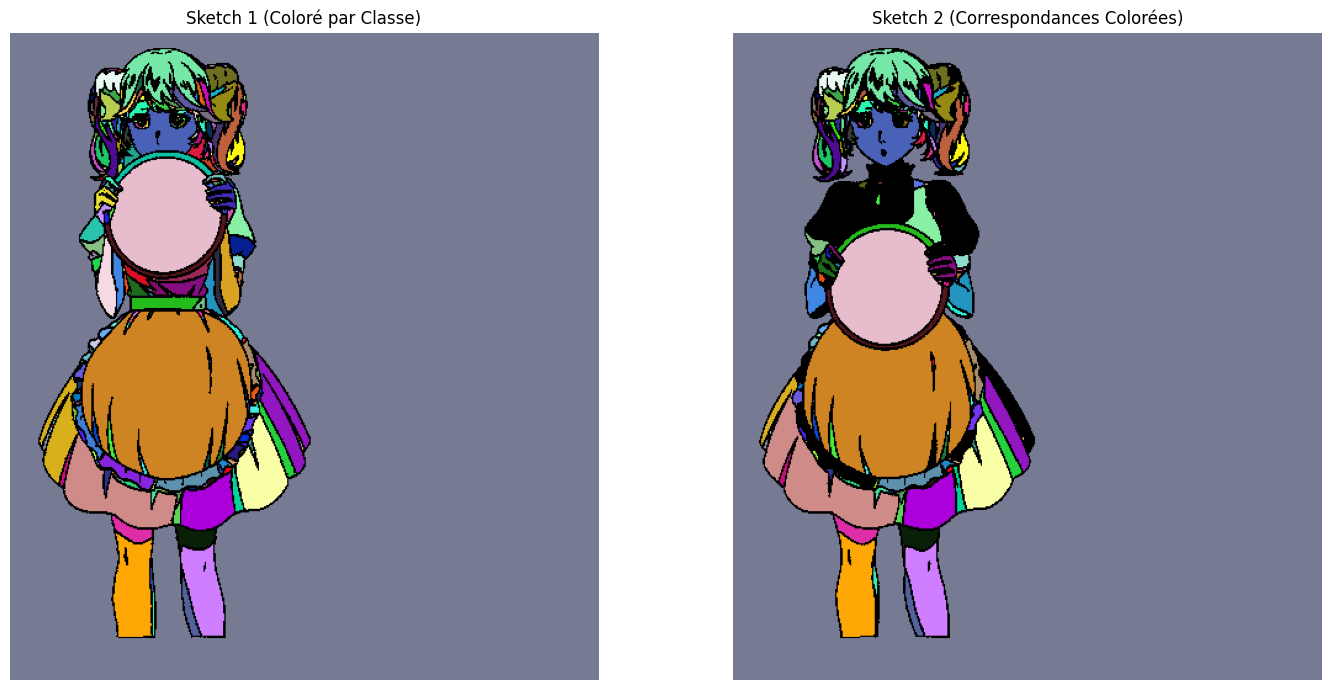

In [35]:
import random
def visualize_class_correspondences(sketch1, sketch2, classes_matrix1, classes_matrix2, class_matches):
    """
    Visualise les classes du sketch 1 et leurs correspondances avec celles du sketch 2.
    """
    # Générer des couleurs aléatoires pour chaque classe
    unique_classes1 = np.unique(classes_matrix1)
    unique_classes1 = unique_classes1[unique_classes1 >= 1]  # Exclure contours et pixels non classés
    class_colors = {cls: [random.randint(0, 255) for _ in range(3)] for cls in unique_classes1}
    
    # Créer des images colorées pour chaque sketch
    colored_sketch1 = np.zeros_like(sketch1)
    colored_sketch2 = np.zeros_like(sketch2)
    
    for class1, color in class_colors.items():
        # Colorer les classes dans le sketch 1
        mask1 = (classes_matrix1 == class1)
        colored_sketch1[mask1] = color
        
        # Trouver la classe correspondante dans le sketch 2
        class2 = class_matches.get(class1)
        if class2 is not None:
            mask2 = (classes_matrix2 == class2)
            colored_sketch2[mask2] = color

    # Afficher les résultats côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(colored_sketch1)
    axes[0].set_title("Sketch 1 (Coloré par Classe)")
    axes[0].axis("off")
    
    axes[1].imshow(colored_sketch2)
    axes[1].set_title("Sketch 2 (Correspondances Colorées)")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()


# Visualiser les correspondances
visualize_class_correspondences(sketch1, sketch2, classes_matrix1, classes_matrix2, class_matches)


#pour de meilleur resultat essayer dentrainer un modèle pour qu'il trouve les ponderations automatiqueùent de manière non supervisé ?


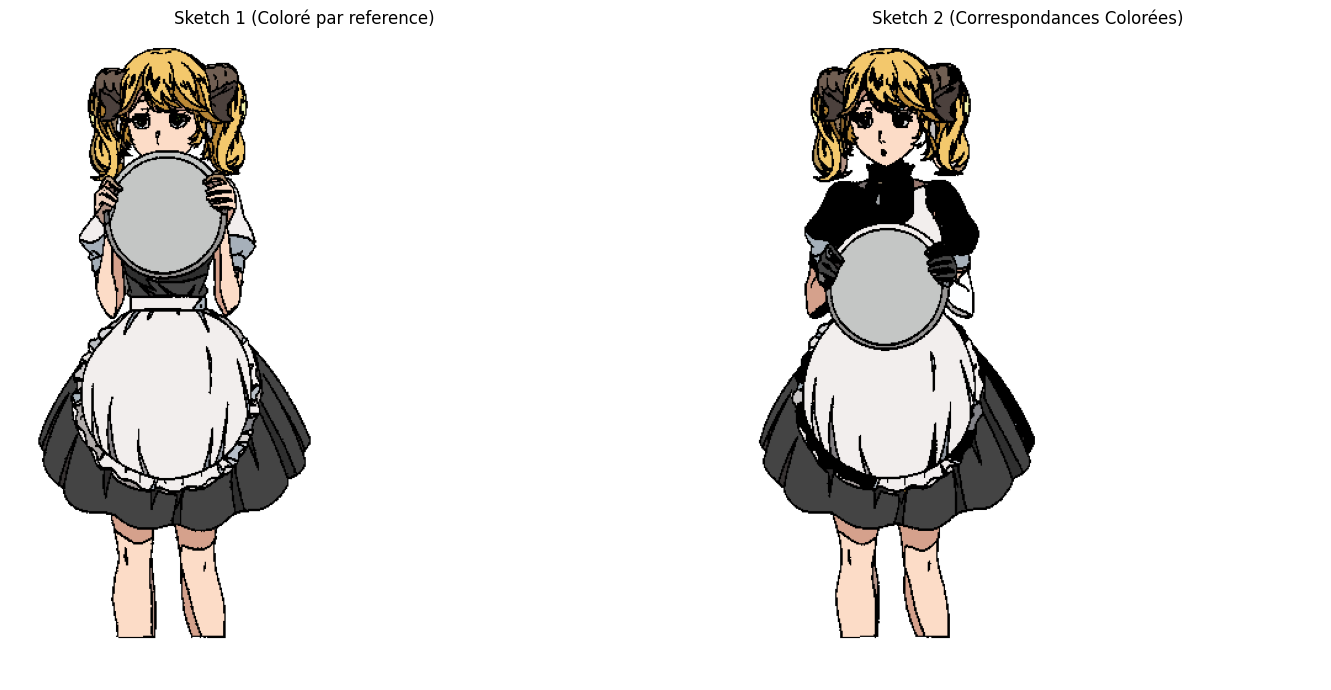

"image_color_from_sketch_prev = apply_class_colors(classes_matrix1,classes_matches_colored)\n\nimage_color_from_sketch_newt = apply_class_colors(classes_matrix2,classes_matches_colored)# assign_color_to_class_from_refernce(classes_matrix2,classes_matches_colored, image_color_from_sketch_prev)# \n\n\nimshow_plt( [image_color_from_sketch_prev,image_color_from_sketch_newt], ['frame 1', ' frame 2'])"

In [36]:
def recategorize_classes(sketch_classes1, sketch_classes2, class_matches):
    """
    Recatégorise les classes dans le sketch 2 en fonction des correspondances avec le sketch 1.
    Les classes du sketch 2 qui matchent avec celles du sketch 1 prennent le numéro de classe
    du sketch 1. Les classes qui ne matchent pas prennent le numéro négatif de leur numéro original.

    Args:
        sketch_classes1 (np.ndarray): Matrice des classes du sketch 1.
        sketch_classes2 (np.ndarray): Matrice des classes du sketch 2.
        class_matches (dict): Dictionnaire des correspondances entre les classes
                              (clé : classe du sketch 1, valeur : classe du sketch 2).

    Returns:
        np.ndarray: Matrice des classes du sketch 2 recatégorisée.
    """
    # Créer une copie de la matrice des classes du sketch 2
    recategorized_classes = np.copy(sketch_classes2)
    unique_classes1 = np.unique(classes_matrix1)
    unique_classes1 = unique_classes1[unique_classes1 >= 1]
    # Appliquer les correspondances
    for class1 in unique_classes1:
                
        # Trouver la classe correspondante dans le sketch 2
        class2 = class_matches.get(class1)
        if class2 is not None:
            mask2 = (classes_matrix2 == class2)
            recategorized_classes[mask2] = class2


    

    return recategorized_classes





def assign_color_to_class_from_refernce(image_classes, list_classes, image_reference):
    """ 
    Associe une couleur à chaque classe à partir d'une image de référence.

    Parameters:
        - image_classes : np.ndarray 
            Matrice des classes associées à chaque pixel.
        - list_classes : list 
            Liste des valeurs des classes.
        - image_reference : np.ndarray
            Image colorée de référence.

    Returns:
        - dict : Dictionnaire associant chaque classe à une couleur.
    """
    class_colors = {}

    for c in list_classes:
        if c < 0:  # Ignorer les classes négatives (-1 ou -2)
            continue
        
        # Masque des pixels appartenant à la classe `c`
        mask = (image_classes == c)
        indices = np.argwhere(mask)

        if len(indices) > 0:
            # Extraire les couleurs de l'image de référence pour les pixels correspondants
            colors = [tuple(image_reference[i, j]) for i, j in indices]
            # Trouver la couleur la plus fréquente
            most_common_color = Counter(colors).most_common(1)[0][0]
            # Assigner la couleur à la classe
            class_colors[c] = most_common_color

    return class_colors


def apply_class_colors(image_classes, class_colors):
    """
    Applique les couleurs définies à chaque classe sur une image des classes.

    Parameters:
        - image_classes : np.ndarray
            Matrice des classes associées à chaque pixel.
        - class_colors : dict
            Dictionnaire associant chaque classe à une couleur.

    Returns:
        - np.ndarray : Image colorée où chaque pixel est coloré en fonction de sa classe.
    """
    # Créer une image de sortie vide avec 3 canaux pour les couleurs
    output_image = np.zeros((*image_classes.shape, 3), dtype=np.uint8)

    for class_, color in class_colors.items():
        # Masque des pixels de la classe `c`

        mask = (image_classes == class_)
            # Appliquer la couleur correspondante à ces pixels
        output_image[mask] = color if(class_>=0) else (0,0,0)

    return output_image

def apply_color_from_reference(sketch1, sketch2, classes_matrix1, classes_matrix2, class_matches,class_colors ):
    """
    Visualise les classes du sketch 1 et leurs correspondances avec celles du sketch 2.
    """
    # Générer des couleurs aléatoires pour chaque classe
    unique_classes1 = np.unique(classes_matrix1)
    unique_classes1 = unique_classes1[unique_classes1 >= 1]  # Exclure contours et pixels non classés
    #class_colors = {cls: [random.randint(0, 255) for _ in range(3)] for cls in unique_classes1}
    
    # Créer des images colorées pour chaque sketch
    colored_sketch1 = np.zeros_like(sketch1)
    colored_sketch2 = np.zeros_like(sketch2)
    
    for class1, color in class_colors.items():
        # Colorer les classes dans le sketch 1
        mask1 = (classes_matrix1 == class1)
        colored_sketch1[mask1] = color
        
        # Trouver la classe correspondante dans le sketch 2
        class2 = class_matches.get(class1)
        if class2 is not None:
            mask2 = (classes_matrix2 == class2)
            colored_sketch2[mask2] = color

    # Afficher les résultats côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(colored_sketch1)#axes[0].imshow(cv2.cvtColor(colored_sketch1, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Sketch 1 (Coloré par reference)")
    axes[0].axis("off")
    
    axes[1].imshow(colored_sketch2)#axes[1].imshow(cv2.cvtColor(colored_sketch2, cv2.COLOR_RGB2BGR))
    axes[1].set_title("Sketch 2 (Correspondances Colorées)")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

classes_matches_colored = assign_color_to_class_from_refernce(classes_matrix1,class_matches, image_references[0])

apply_color_from_reference(sketch1, sketch2, classes_matrix1, classes_matrix2, class_matches,classes_matches_colored )
#classes_matrix2 = recategorize_classes(classes_matrix1,classes_matrix2,class_matches) 


"""image_color_from_sketch_prev = apply_class_colors(classes_matrix1,classes_matches_colored)

image_color_from_sketch_newt = apply_class_colors(classes_matrix2,classes_matches_colored)# assign_color_to_class_from_refernce(classes_matrix2,classes_matches_colored, image_color_from_sketch_prev)# 


imshow_plt( [image_color_from_sketch_prev,image_color_from_sketch_newt], ['frame 1', ' frame 2'])"""


In [37]:
# creer des modle qui optimize la sepration. en données dentrainement données les image coloré deux a deux. 
# on peut essayer croiser les frame pour avoir plus de data
#Voire comment recuperer uniquement les contours dans des fichier danimations et essayer dentrainer sur ca 



(555, 360, 3)


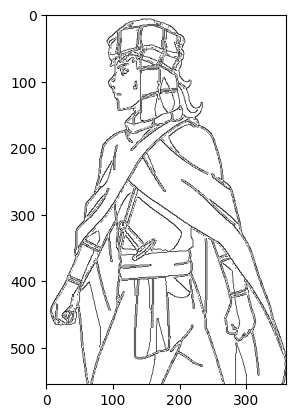

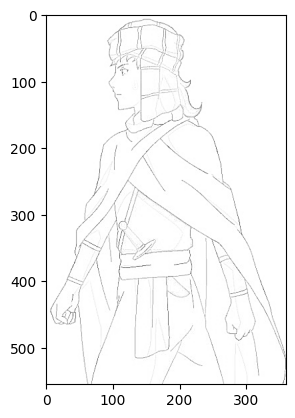

(555, 360, 3)


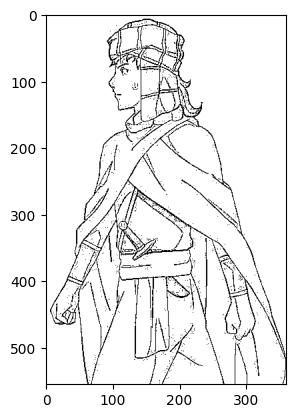

In [130]:
# 1 color = 1 class , so i can trin on color images by getting the contours, create the classes and mtching the classes with the next image. lets try on two colored images 
import skimage.morphology

test_colored_images = [ cv2.cvtColor(cv2.imread("dataset/train/colored/sequence3/1.jpg"), cv2.COLOR_BGR2RGB ),cv2.cvtColor(cv2.imread("dataset/train/colored/sequence3/7.jpg"), cv2.COLOR_BGR2RGB ),cv2.cvtColor(cv2.imread("dataset/train/colored/sequence3/11.jpg"), cv2.COLOR_BGR2RGB )]


def extract_contours_with_canny_inverted(image, low_threshold=50, high_threshold=70):
    """
    Extract contours from an image using the Canny edge detector and invert the edges.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, low_threshold, high_threshold)

    # Invert the edges: Make edges black and background white
    inverted_edges = cv2.bitwise_not(edges)

    # Find contours from the edges
    image_edges = cv2.cvtColor(inverted_edges, cv2.COLOR_GRAY2BGR)
    return  image_edges

def colored_to_line(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted = 255 - gray
    blurred = cv2.GaussianBlur(inverted, (5,5),0)
    invertedblur = 255 - blurred
    lines = cv2.divide(gray, invertedblur, scale=256.0)
    return cv2.cvtColor(lines, cv2.COLOR_GRAY2BGR)

# Nettoyer le bruit
def reduce_noise(img):
    """
    Reduce noise from an edge-detected image.
    Parameters:
        img : np.ndarray
            Input binary image
    Returns:
        np.ndarray: Cleaned image with reduced noise
    """
    # Appliquer un filtre médian pour supprimer les points isolés
    denoised = cv2.medianBlur(img, 1)
    
    # Appliquer une ouverture morphologique (érosion + dilatation)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    
    return cleaned

# Process the first image
edges = extract_contours_with_canny_inverted(test_colored_images[0])
print(edges.shape)
imshow_cv(threshold(edges,200))


edges2 = colored_to_line(test_colored_images[0])
edges2Noisy = threshold((edges2),247)
#edges2Noisy_cleaned = reduce_noise(edges2Noisy)


# Create a Gaussian Filter
filter_size = 11
filter_sigma = 2
filter = cv2.getGaussianKernel(filter_size, filter_sigma)
filter = filter * filter.T

# Apply it to remove noise
#edges2Noisy_cleaned = extract_contours_with_canny_inverted(edges2, 20,80)


imshow_cv(edges2)
print(edges2Noisy.shape)
imshow_cv(edges2Noisy)


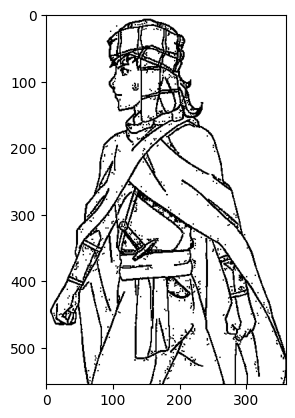

In [ ]:
# il ya des problemes donc il faut que je nettoie le sketch
def clean_edges(edges):

    # Kernel pour les transformations morphologiques
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    # Dilatation pour combler les trous
    #dilated = cv2.dilate(edges, kernel, iterations=1)

    # Erosion pour affiner les bords
    cleaned = cv2.erode(edges, kernel, iterations=1)

    return cleaned
cleaned_edges_image =(clean_edges(edges2Noisy))
imshow_cv(cleaned_edges_image)
#classes_matrix_edges, classes_matrix_list_num= assign_class_to_pixel_by_filling(cleaned_edges_image, filling)
#imshow_cv(classes_matrix_to_image(classes_matrix_edges, classes_matrix_list_num))

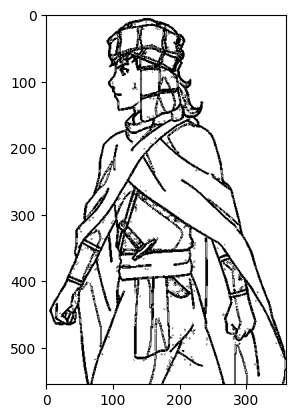

'classes_matrix_edges, classes_matrix_list_num= assign_class_to_pixel_by_filling(egdes_gradient)\nimshow_cv(classes_matrix_to_image(classes_matrix_edges, classes_matrix_list_num))'

In [ ]:

def gradient_sobel_color_edges_multithreshold(image, thresholds=[10]):

    # Split the channels of the image
    b, g, r = cv2.split(image)

    # Compute gradients for each channel
    grad_x_r = cv2.Sobel(r, cv2.CV_64F, 1, 0, ksize=1)
    grad_y_r = cv2.Sobel(r, cv2.CV_64F, 0, 1, ksize=1)
    grad_x_g = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=1)
    grad_y_g = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=1)
    grad_x_b = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=1)
    grad_y_b = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=1)

    # Calculate the magnitude for each channel
    grad_magnitude_r = cv2.magnitude(grad_x_r, grad_y_r)
    grad_magnitude_g = cv2.magnitude(grad_x_g, grad_y_g)
    grad_magnitude_b = cv2.magnitude(grad_x_b, grad_y_b)

    # Combine magnitudes
    combined_magnitude = np.sqrt(
        grad_magnitude_r**2 + grad_magnitude_g**2 + grad_magnitude_b**2
    )
    combined_magnitude = np.uint8(255 * combined_magnitude / np.max(combined_magnitude))

    # Initialize an empty canvas for combining edges
    combined_edges = np.zeros_like(combined_magnitude)

    # Iterate over thresholds
    for threshold in thresholds:
        # Apply thresholding to extract edges
        _, edges = cv2.threshold(combined_magnitude, threshold, 255, cv2.THRESH_BINARY)

        # Add the edges to the combined result
        combined_edges = cv2.bitwise_or(combined_edges, edges)
    combined_edges_skeleton = skimage.morphology.skeletonize(combined_edges // 255).astype(np.uint8) * 255
    # Create a white background and invert the edges for display
    edges_on_white = np.ones_like(combined_edges_skeleton) * 255
    edges_on_white[combined_edges == 255] = 0
    edges_rgb = cv2.cvtColor(edges_on_white, cv2.COLOR_GRAY2BGR)

    return edges_rgb



egdes_gradient =(gradient_sobel_color_edges_multithreshold(edges2)) #(gradient_sobel_color_edges_multithreshold(test_colored_images[0]))
imshow_cv(egdes_gradient)


"""classes_matrix_edges, classes_matrix_list_num= assign_class_to_pixel_by_filling(egdes_gradient, filling)
imshow_cv(classes_matrix_to_image(classes_matrix_edges, classes_matrix_list_num))"""

(557, 362)
(555, 360)
Classe 1.0 dans Sketch 1 correspond à Classe 1.0 dans Sketch 2
Classe 2.0 dans Sketch 1 correspond à Classe 2.0 dans Sketch 2
Classe 3.0 dans Sketch 1 correspond à Classe 3.0 dans Sketch 2
Classe 4.0 dans Sketch 1 correspond à Classe 4.0 dans Sketch 2
Classe 5.0 dans Sketch 1 correspond à Classe 5.0 dans Sketch 2
Classe 6.0 dans Sketch 1 correspond à Classe 101.0 dans Sketch 2
Classe 7.0 dans Sketch 1 correspond à Classe 7.0 dans Sketch 2
Classe 8.0 dans Sketch 1 correspond à Classe 8.0 dans Sketch 2
Classe 9.0 dans Sketch 1 correspond à Classe 25.0 dans Sketch 2
Classe 10.0 dans Sketch 1 correspond à Classe 10.0 dans Sketch 2
Classe 11.0 dans Sketch 1 correspond à Classe 9.0 dans Sketch 2
Classe 12.0 dans Sketch 1 correspond à Classe 11.0 dans Sketch 2
Classe 13.0 dans Sketch 1 correspond à Classe 12.0 dans Sketch 2
Classe 14.0 dans Sketch 1 correspond à Classe 13.0 dans Sketch 2
Classe 15.0 dans Sketch 1 correspond à Classe 13.0 dans Sketch 2
Classe 16.0 dans Sk

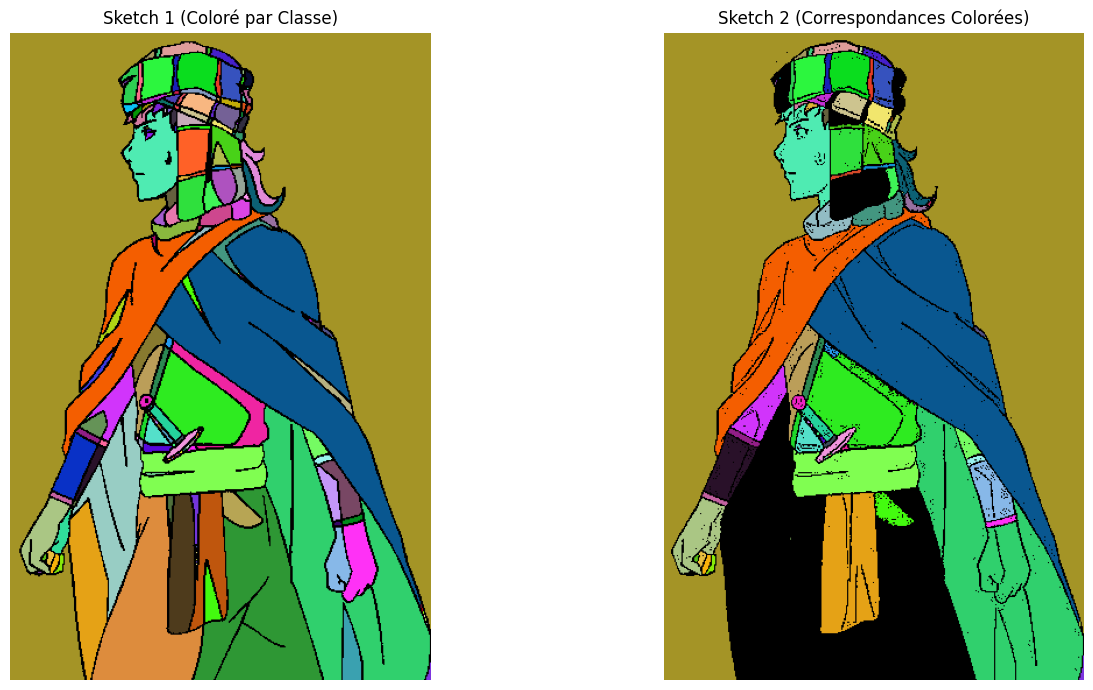

IndexError: index 360 is out of bounds for axis 1 with size 360

In [184]:

# Étape 1: Segmenter les deux sketchs
classes_matrix1, _ = assign_class_to_pixel_by_filling(myimage_denoised, "basic_filling")
classes_matrix2, _ = assign_class_to_pixel_by_filling(edges2Noisy, "basic_filling")

# Étape 2: Extraire les régions par classe
regions1 = extract_regions_by_class(classes_matrix1)
regions2 = extract_regions_by_class(classes_matrix2)

# Étape 3: Calculer les descripteurs pour chaque région
descriptors1 = compute_invariant_descriptors(sketch1, regions1)#compute_invariant_descriptors_with_proximity(sketch1, regions1) #
descriptors2 =  compute_invariant_descriptors(sketch2, regions2)#compute_invariant_descriptors_with_proximity(sketch2, regions2)#

# Étape 4: Trouver les correspondances entre les classes
class_matches = match_classes(descriptors1, descriptors2)#compute_invariant_descriptors_with_proximity(descriptors1, descriptors2)#

# Afficher les correspondances
for class1, class2 in class_matches.items():
    print(f"Classe {class1} dans Sketch 1 correspond à Classe {class2} dans Sketch 2")

visualize_class_correspondences(myimage_denoised, clean_edges(edges), classes_matrix1, classes_matrix2, class_matches)

classes_matches_colored = assign_color_to_class_from_refernce(classes_matrix1,class_matches, test_colored_images[0])

apply_color_from_reference(myimage_denoised, clean_edges(edges), classes_matrix1, classes_matrix2, class_matches,classes_matches_colored )
#on voit bien que les match entre les 